In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

try:
    xrange = xrange
except:
    xrange = range

In [2]:
env = gym.make('CartPole-v1')

In [3]:
gamma = 0.99

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [4]:
class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        hidden = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,a_size,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [22]:
tf.reset_default_graph() #Clear the Tensorflow graph.

myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8) #Load the agent.

total_episodes = 2000 #Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

records = []

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 1
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes+1:
        s = env.reset()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            #Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if d == True:
                #Update the network.
                ep_history = np.array(ep_history)
                #print ep_history.shape
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
            #Update our running tally of scores.
        if i % 100 == 0:
            print "episode %d:"%i,(np.mean(total_reward[-100:]))
        if i % update_frequency == 0:
            records.append([i,np.mean(total_reward[-5:]),np.std(total_reward[-5:])])
        i += 1

episode 100: 21.95
episode 200: 26.89
episode 300: 30.92
episode 400: 38.69
episode 500: 54.62
episode 600: 71.07
episode 700: 95.01
episode 800: 159.96
episode 900: 197.33
episode 1000: 219.1
episode 1100: 164.76
episode 1200: 165.28
episode 1300: 253.77
episode 1400: 241.76
episode 1500: 214.73
episode 1600: 214.59
episode 1700: 244.34
episode 1800: 207.74
episode 1900: 165.49
episode 2000: 175.31


(400, 3)


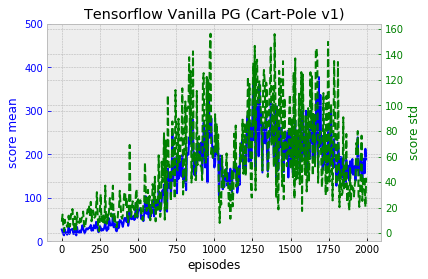

In [24]:
%matplotlib inline
import seaborn
plt.style.use('bmh')
arr = np.asarray(records)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0]*5,5)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,1], 'b-')
ax1.set_xlabel('episodes')
#ax1.set_xticks(ind[::20])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.set_ylim(0,500)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,2], 'g--')
ax2.set_ylabel('score std', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('Tensorflow Vanilla PG (Cart-Pole v1)');